In [1]:
%matplotlib inline
import numpy as np
from numpy import sqrt
import scipy.constants
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import VoigtModel
import scipy.special
import os
from ipywidgets import interact, fixed

m_e=scipy.constants.m_e
m_p=scipy.constants.m_p
e=scipy.constants.e
c=scipy.constants.c

In [2]:
#round to n significant figures, good for stringifying.
round_to_n = lambda x, n: round(x, -int(np.floor(np.log10(np.abs(x)))) + (n - 1)) 

def convolve(arr, kernel):
    # simple convolution of two arrays
    # can't remember where I took this from or how it works, but it does.
    npts = min(len(arr), len(kernel))
    pad = np.ones(npts)
    tmp = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

def S_k_omega_V3D(lambda_range, lambda_in, theta_0, theta, phi, A, T_e,T_i,n_e,Z, V_fi, theta_V, phi_V):
    '''
    Spectral density function fo a plasma with electrons but not ions magnetised
    Full 3D vector implementation to account for the anisotropy of a Maxwellian in a magnetic field.
    Returns a normalised spectral density function.
    Implements the model of Sheffield (2nd Ed.)
    One ion, one electron species with independent temperatures
    Returns S(k,w) for each wavelength in lambda_range assuming
    input wavelength lambda_in. Both in metres
    Theta is angle between k_in and k_s in degrees
    Phi is the angle below the plane formed by k_in and the centre of the aperture in degrees
    Confusing, phi_B is the angle the magnetic field makes with k_i in the plane
    And psi_B is the angle the magnetic field makes with the plane
    B is in Tesla
    A i atomic mass, Z is ion charge
    T_e, T_i in eV, n_e in cm^-3
    V_fi and V_fe in m/s
    Does not reduce to unmagnetised function for low B due to the approximations use
    Does not properly implement V_fi and V_fe. These should always be 0.
    '''
    #physical parameters
    pi=np.pi
    m_i=m_p*A
    om_pe=5.64e4*n_e**0.5#electron plasma frequency
    #define omega and k as in Sheffield 113
    ki=2*pi/lambda_in
    omega_i=((c*ki)**2+om_pe**2)**0.5
    th0=theta_0/180.0*np.pi#convert to radians for cos, sin funcs.
    ki_vec=np.array([np.sin(th0),0.0,np.cos(th0)])*ki#vector ki in direction [0,1,0]
    
    ks=2*pi/lambda_range
    omega_s=((c*ks)**2+om_pe**2)**0.5
    th=theta/180.0*np.pi#convert to radians for cos, sin funcs.
    ph=phi/180.0*np.pi
    ks_vec=np.array([[ksi*np.sin(th)*np.cos(ph),ksi*np.sin(th)*np.sin(ph), ksi*np.cos(th)] for ksi in ks])
    
    k_vec=ks_vec-ki_vec#vector k given by difference of two
    k=np.array([np.sqrt(kvi[0]**2+kvi[1]**2+kvi[2]**2) for kvi in k_vec])#magnitude, (k_x**2+k_y**+k_z**2)**0.5
    omega=omega_s-omega_i#corresponding frequency shift
    
    th_V=theta_V/180.0*np.pi#phi_B defined wrt to k_i in plane
    ph_V=phi_V/180.0*np.pi#psi_B defined wrt to k_i out of plane
    
    V=V_fi*np.array([np.sin(th_V)*np.cos(ph_V), np.sin(th_V)*np.sin(ph_V), np.cos(th_V)])#unit vector in direction of B
    
    #define dimensionless parameters ala Sheffield
    a=sqrt(2*e*T_e/m_e)
    b=sqrt(2*e*T_i/m_i)
    kdotV=np.array([np.vdot(kk, V) for kk in k_vec])
    x_i=(omega+kdotV)/(k*b)
    x_e=(omega+kdotV)/(k*a)
    lambda_De=7.43*(T_e/n_e)**0.5 #Debeye length in m
    #the all important alpha parameter
    alpha=1/(k*lambda_De)
    #set up the Fadeeva function
    w=scipy.special.wofz
    chi_i=alpha**2*Z*T_e/T_i*(1+1j*sqrt(pi)*x_i*w(x_i)) #ion susceptibility
    chi_e=alpha**2*(1+1j*sqrt(pi)*x_e*w(x_e))#electron susceptibility
    epsilon=1+chi_e+chi_i#dielectric function
    fe0=1/(sqrt(pi)*a)*np.exp(-x_e**2)#electron Maxwellian function
    fi0=1/(sqrt(pi)*b)*np.exp(-x_i**2)#ion Maxwellian
    Skw=2*pi/k*abs(1-chi_e/epsilon)**2*fe0+Z*abs(chi_e/epsilon)**2*fi0
    return Skw/Skw.max() #normalise the spectrum

def aperture_integ_and_convolve(func, aperture_angle, steps, response):
    '''
    Integrates a given function over sin(theta) dtheta dphi over 2pi in phi 
    and from 0 to aperture_angle in theta. func must accept only two arguemnts,
    theta and phi, so a lambda function is helpful to fix other parameters
    Afterwards, convolves with a given response function.
    '''
    res=[]
    aa=aperture_angle
    for t in np.linspace(aa/steps, aa, steps): #don't bother evaluating t=0, as sin(0)=0
        for p in np.linspace(0, 360.0, steps):
            res.append(np.sin(t)*func(t,p))
    res=np.sum(res,0)
    res_conv=convolve(response,res)
    res_conv_norm=res_conv/res_conv.max()
    return res_conv_norm

skw_th_ph=lambda th, ph: S_k_omega_V3D(l,lambda_in=l0, theta=th, theta_0=theta_0, phi=ph,
                                       A=A,Z=Z,
                                       T_e=T_e,T_i=T_i,n_e=n_e, V_fi=V_fi, theta_V=thV, phi_V=phV)

def S_k_omega(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z, v_fi=0, v_fe=0):
    '''
    Returns a normalised spectral density function.
    Implements the model of Sheffield (2nd Ed.)
    One ion, one electron species with independent temeperatures
    Electron velocity is with respect to ion velocity
    Returns S(k,w) for each wavelength in lambda_range assuming
    input wavelength lambda_in. Both in metres
    Theta is angle between k_in and k_s in degrees
    A i atomic mass, Z is ion charge
    T_e, T_i in eV, n_e in cm^-3
    V_fi and V_fe in m/s
    '''
    #physical parameters
    pi=np.pi
    m_i=m_p*A
    om_pe=5.64e4*n_e**0.5#electron plasma frequency
    #define omega and k as in Sheffield 113
    ki=2*pi/lambda_in
    omega_i=((c*ki)**2+om_pe**2)**0.5

    ks=2*pi/lambda_range
    omega_s=((c*ks)**2+om_pe**2)**0.5
    
    th=theta/180.0*np.pi#convert to radians for cosine function
    k=(ks**2+ki**2-2*ks*ki*np.cos(th))**0.5
    omega=omega_s-omega_i
    
    #define dimensionless parameters ala Sheffield
    a=sqrt(2*e*T_e/m_e)
    b=sqrt(2*e*T_i/m_i)
    x_e=(omega+k*v_fe+k*v_fi)/(k*a)
    x_i=(omega+k*v_fi)/(k*b)
    lambda_De=7.43*(T_e/n_e)**0.5 #Debeye length in m
    #the all important alpha parameter
    alpha=1/(k*lambda_De)
    #set up the Fadeeva function
    w=scipy.special.wofz
    chi_i=alpha**2*Z*T_e/T_i*(1+1j*sqrt(pi)*x_i*w(x_i)) #ion susceptibility
    chi_e=alpha**2*(1+1j*sqrt(pi)*x_e*w(x_e))#electron susceptibility
    epsilon=1+chi_e+chi_i#dielectric function
    fe0=1/(sqrt(pi)*a)*np.exp(-x_e**2)#electron Maxwellian function
    fi0=1/(sqrt(pi)*b)*np.exp(-x_i**2)#ion Maxwellian
    Skw=2*pi/k*abs(1-chi_e/epsilon)**2*fe0+Z*abs(chi_e/epsilon)**2*fi0
    return Skw/Skw.max() #normalise the spectrum

def S_k_omega_conv(lambda_range, lambda_in, response, theta, A, T_e,T_i,n_e,Z, v_fi=0, v_fe=0, amp=1.0):
    '''
    Takes the Spectral density function and convolves it with a given Instrument Response.
    It's necessary to have an extra function just to do this for lmfit.
    Otherwise it would be ridiculous.
    '''
    skw=S_k_omega(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z, v_fi, v_fe)
    skw_conv=convolve(response,skw)
    return amp*skw_conv/skw_conv.max()

In [10]:
l=np.linspace(531,533,2000)*1e-9 #generate an array of wavelengths in nm
l0=532e-9#central wavelength
vm=VoigtModel()#Borrow a Voigt profile from the lmfit package to use as our response function
#Response centered on l0, width 0.16 Angstrom as experimentally measured. 
#To view the unconvolved spectrum, I suggest reducing sigma to 1e-13.
resp=vm.eval(x=l, center=l0,gamma=1.41e-11, sigma=1.27e-11,amplitude=1.0)

'''Plasma Parameters'''
n_e=1e18#cm^-3
A=27#Ion mass
Z=5#Ion charge
T_i=30#in eV
T_e=30#in eV
V_fi=0#in ms^-1


'''Scattering angle'''
theta_0=60#in degrees, angle between k_in and k_s
thV=0
phV=90

'''Aperture'''
theta_A=2#aperture half opening angle in degrees
steps=30 #number of integration steps. Time taken to computer scales as the square. Try 11.

skw=S_k_omega_conv(l, response=resp,lambda_in=l0, theta=theta_0,A=A,T_e=T_e,T_i=T_i,n_e=n_e,Z=Z, v_fi=V_fi)
skw_V3d_1=aperture_integ_and_convolve(skw_th_ph, 1.3,steps, resp)
skw_V3d_2=aperture_integ_and_convolve(skw_th_ph, 2.5,steps, resp)

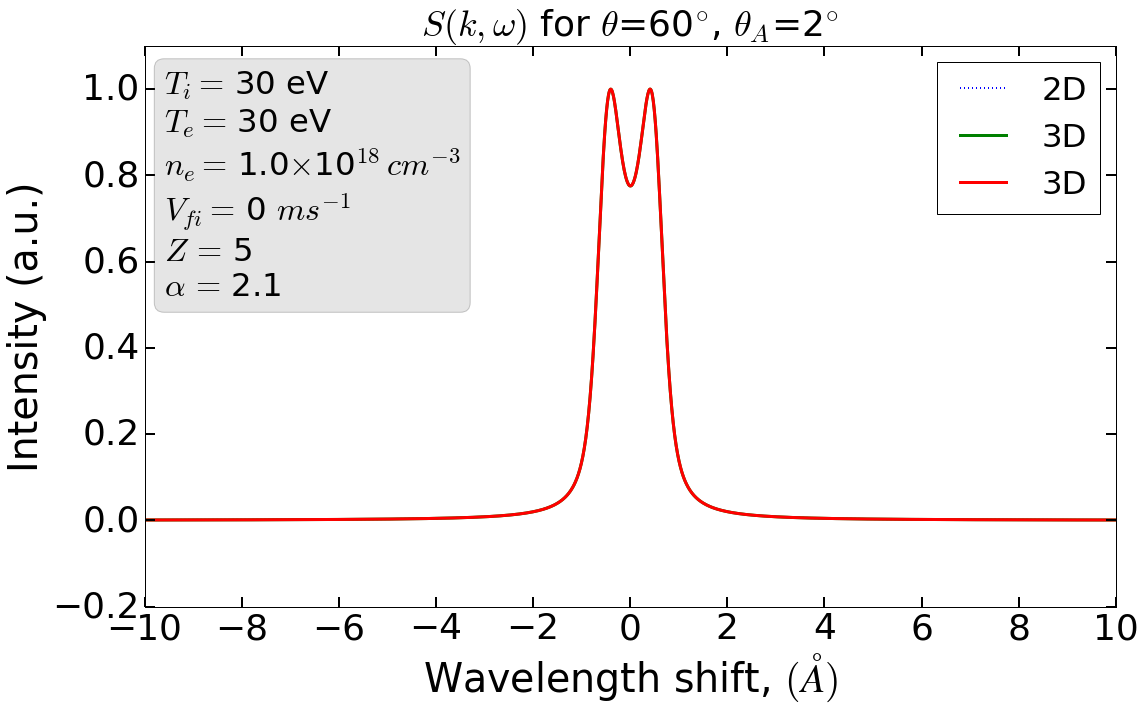

In [11]:
text_mul=1.8
fig,ax=plt.subplots(figsize=(16,10))
wl_Angs=1e10*(l-l.mean())#the wavelength range, in angstroms, as a shift from the centre.
plt.plot(wl_Angs, skw, ':',lw=2, label='2D')
plt.plot(wl_Angs, skw_V3d_1,lw=3, label='3D')
plt.plot(wl_Angs, skw_V3d_2,lw=3, label='3D')

#plt.plot(wl_Angs, (skw_V3d-skw)*10,lw=3, label='diff')

#plotting region
ax.set_ylim([-0.2,1.1])
sr=10 #x-range in angstroms to plot
ax.set_xlim([-sr,sr])
ax.set_xticks(np.linspace(-sr,sr,sr+1))
ax.set_xlabel(r'Wavelength shift, $(\AA)$',fontsize=22*text_mul)
ax.set_ylabel('Intensity (a.u.)',fontsize=22*text_mul)
ax.tick_params(labelsize=20*text_mul, pad=5, length=10, width=2)

#Quickly calculate alpha for the info-box
lambda_De=7.43*(T_e/n_e)**0.5 #in m
th=theta_0/180.0*np.pi
k=2.0**1.5*np.pi/l0*(1-np.cos(th))**0.5
alpha=np.abs(1/(k*lambda_De))
#makes strings from all the paramters for the info-box
ti = r'$T_i=\,$'+str(T_i)+' eV'
te = r'$T_e=\,$'+str(T_e)+' eV'
vfi = r'$V_{fi}=\,$'+str(V_fi)+r' $ms^{-1}$'
ne = r'$n_e=\,$'+str(n_e/1e18)+r'$\times$10$^{18}\,cm^{-3}$'
alp = r'$\alpha\,=\,$'+str(round_to_n(alpha, 2))
textstr= (ti+'\n'+te+'\n'
          +ne+'\n'
          +vfi+'\n'
          +'$Z\,=\,$'+str(Z)+'\n'
          +alp)
# these are matplotlib.patch.Patch properties for the info-box
props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
# place an info box in upper left in axes coords
ax.text(0.02, 0.96, textstr, transform=ax.transAxes, fontsize=18*text_mul,
        verticalalignment='top', bbox=props)

#Plot title
deg=r'$^{\circ} $'#little degree symbol
th_st=r'$\theta$='+str(theta_0)+deg
ta_st=r'$\theta_A$='+str(theta_A)+deg
title=r'$S(k,\omega)$ for '+th_st+', '+ta_st
ax.set_title(title,fontsize=20*text_mul, y=1.01)

#Plot legend
ax.legend(fontsize=18*text_mul)

plt.tight_layout()

In [90]:
5/(2.0*43)*180.0/np.pi

3.3311499716908326